# IMPORTS

In [5]:
from glob import glob
import os, pandas as pd
import cv2, numpy as np
import matplotlib.pyplot as plt
from segmentation_models import *
from segmentation_models.metrics import iou_score
import shutil
import pickle

Segmentation Models: using `keras` framework.


# LEITURA DATAFRAME

In [17]:
df = pd.read_csv('/home/lucas_araujo/pibic-2024/dataset/Data_Entry_2017.csv')
df = df.loc[:,['Image Index','Patient ID', 'Finding Labels']]
img_paths={os.path.basename(x): x for x in glob(os.path.join('.', '/home/lucas_araujo/pibic-2024/dataset', 'images*','images','*.png'))} 
df['path']=df['Image Index'].map(img_paths.get) #mapping image ids to all image paths
df

,Image Index,Patient ID,Finding Labels,path
0,00000001_000.png,1,Cardiomegaly,/home/lucas_araujo/pibic-2024/dataset/images_0...
1,00000001_001.png,1,Cardiomegaly|Emphysema,/home/lucas_araujo/pibic-2024/dataset/images_0...
2,00000001_002.png,1,Cardiomegaly|Effusion,/home/lucas_araujo/pibic-2024/dataset/images_0...
3,00000002_000.png,2,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...
4,00000003_000.png,3,Hernia,/home/lucas_araujo/pibic-2024/dataset/images_0...
...,...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia,/home/lucas_araujo/pibic-2024/dataset/images_0...
112116,00030802_000.png,30802,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...
112117,00030803_000.png,30803,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...
112118,00030804_000.png,30804,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...


In [37]:
# def save_masks(pred, names, output):
#     """
#         Salva as máscaras geradas

#         Parameters
#         ----------
#         pred: array-like, float32
#             Array contendo todas as máscaras preditas
#         names: list, 'string'
#             Lista de nomes dos arquivos das imagens
#         output: string
#             Nome do diretório onde as imagens serão salvas
            
#     """
#     for i in range(pred.shape[0]):
#         m = pred[i, :, :, 0]
#         cv2.imwrite(output + names[i] + '.png', 255 * ((m - m.min())/(m.max() - m.min())))

In [ ]:
# batch = []
# names = []
# i = 1
# BACKBONE = 'densenet169'
# name = 'Unet'
# # model = Unet(BACKBONE, input_shape=(512, 512, 3), classes=1)
# # model.load_weights('/home/lucas_araujo/pibic-2024/classificacao_multilabel_chest/segm_model/segm_models/Unet/weights/densenet169_best_weights.hdf5')
# pre_processing = get_preprocessing(BACKBONE)

# os.makedirs("./mask_chest", exist_ok=True)

# output_dir_base = 'mask_chest/images_'  # Diretório base para salvar as imagens
# output_dir_counter = 0

# for (path, name) in zip(df['path'], df['Image Index']):
#     img = cv2.imread(path)
#     img = cv2.resize(img, (512, 512))
#     batch.append(img)
#     names.append(name)
#     print(f"{i}/1000")
#     if i % 1000 == 0:
#         output_dir = f'{output_dir_base}{output_dir_counter}/'
#         os.makedirs(output_dir, exist_ok=True)

#         batch = np.array(batch)
#         model = Unet(BACKBONE, input_shape=(512, 512, 3), classes=1)
#         model.load_weights('/home/lucas_araujo/pibic-2024/classificacao_multilabel_chest/segm_model/segm_models/Unet/weights/densenet169_best_weights.hdf5')
#         X = pre_processing(batch)
#         pred = model.predict(X, verbose=1)

#         # Salvar masks dentro da pasta específica
#         save_masks(pred, names, output_dir)

#         # Limpar os batches e nomes
#         batch = []
#         names.clear()

#         # Incrementar o contador de diretório
#         output_dir_counter += 1

#     i += 1

# # Processar os dados restantes
# if batch:
#     output_dir = f'{output_dir_base}{output_dir_counter}/'
#     os.makedirs(output_dir, exist_ok=True)

#     batch = np.array(batch)
#     X = pre_processing(batch)
#     pred = model.predict(X, verbose=1)

#     # Salvar masks dentro da pasta específica
#     save_masks(pred, names, output_dir)

# Gerar Crops

In [7]:
# paths_masks={os.path.basename(x): x for x in glob(os.path.join('.', '/home/lucas_araujo/pibic-2024/dataset_segm/mask_chest/', 'images_*','*.png'))} 
# novo_path_masks = {chave.replace('.png.png', '.png'): valor for chave, valor in paths_masks.items()}
# df['path_masks']=df['Image Index'].map(novo_path_masks.get) #mapping image ids to all image paths
# labels = df['Finding Labels'].str.get_dummies('|')
# df = pd.concat([df, labels], axis=1)

In [56]:
df

,Image Index,Patient ID,Finding Labels,path,path_masks,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,Cardiomegaly,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,Cardiomegaly|Emphysema,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,Cardiomegaly|Effusion,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,3,Hernia,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,30802,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,30803,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,30804,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [52]:
# a = '/home/lucas_araujo/pibic-2024/dataset_segm/mask_chest/images_3/00000001_000.png.png'
# indice_images_0 = a.find('/images_*')
# parte_desejada = a[:indice_images_0 + len('/images_0')]
# parte_desejada

'/home/lu'

## Visualizar original, Máscara, Crop

In [9]:
df

,Image Index,Patient ID,Finding Labels,path
0,00000001_000.png,1,Cardiomegaly,/home/lucas_araujo/pibic-2024/dataset/images_0...
1,00000001_001.png,1,Cardiomegaly|Emphysema,/home/lucas_araujo/pibic-2024/dataset/images_0...
2,00000001_002.png,1,Cardiomegaly|Effusion,/home/lucas_araujo/pibic-2024/dataset/images_0...
3,00000002_000.png,2,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...
4,00000003_000.png,3,Hernia,/home/lucas_araujo/pibic-2024/dataset/images_0...
...,...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia,/home/lucas_araujo/pibic-2024/dataset/images_0...
112116,00030802_000.png,30802,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...
112117,00030803_000.png,30803,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...
112118,00030804_000.png,30804,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...


[  0 255]


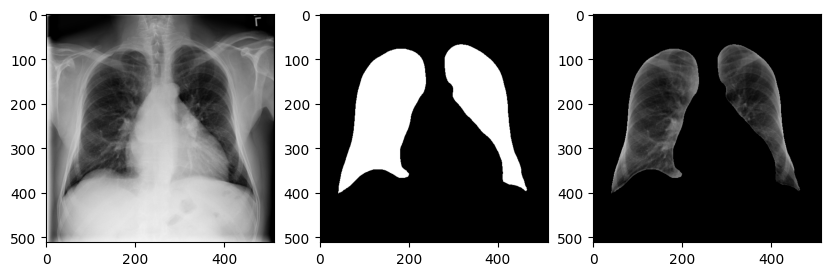

In [62]:
# i=0
# for (path, mask_path) in zip(df['path'], df['path_masks']):
#     image = cv2.imread(path)
#     mask = cv2.imread(mask_path)
#     # image = image.astype('uint8')
#     # mask = mask.astype('uint8')
#     mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#     _, thresholded_mask = cv2.threshold(mask_gray, 127, 255, cv2.THRESH_BINARY)
#     print(np.unique(thresholded_mask))

#     image = cv2.resize(image, (mask.shape[1], mask.shape[0]))
#     # mask_2 = cv2.bitwise_not(mask_gray)

#     Mask = cv2.bitwise_and(image, image, mask = thresholded_mask)  
#     plt.figure(figsize=(10, 5))  # Ajuste o tamanho conforme necessário

#     plt.subplot(1, 3, 1)
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Converte de BGR para RGB para o matplotlib

#     plt.subplot(1, 3, 2)
#     plt.imshow(cv2.cvtColor(thresholded_mask, cv2.COLOR_BGR2RGB))
    
#     plt.subplot(1, 3, 3)
#     plt.imshow(cv2.cvtColor(Mask, cv2.COLOR_BGR2RGB))
#     plt.show()

#     i+=1
#     if(i==1):
#         break

# Salvando Crops em disco

In [70]:
# i=0
# output_dir_base = "/home/lucas_araujo/pibic-2024/dataset_segm/mask_chest_crop/"
# os.makedirs(output_dir_base, exist_ok=True)
# for (name, path, mask_path) in zip(df['Image Index'],df['path'], df['path_masks']):
#     # if(i==300):
#     #     break
#     image = cv2.imread(path)
#     mask = cv2.imread(mask_path)
#     mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#     _, thresholded_mask = cv2.threshold(mask_gray, 127, 255, cv2.THRESH_BINARY)
#     image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

#     # Aplicando máscara
#     masked_image = cv2.bitwise_and(image, image, mask = thresholded_mask)
#     # Salvar as imagens
#     cv2.imwrite(os.path.join(output_dir_base, f"{name}"), masked_image)
#     i+=1

   

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


# Juntar Dataframe(Imagens Globais e Crops)

In [18]:
paths_crops={os.path.basename(x): x for x in glob(os.path.join('.', '/home/lucas_araujo/pibic-2024/dataset_segm/mask_chest_crop/','*.png'))}
paths_crops 
df['path_crop']=df['Image Index'].map(paths_crops.get) #mapping image ids to all image paths
df

,Image Index,Patient ID,Finding Labels,path,path_crop
0,00000001_000.png,1,Cardiomegaly,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...
1,00000001_001.png,1,Cardiomegaly|Emphysema,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...
2,00000001_002.png,1,Cardiomegaly|Effusion,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...
3,00000002_000.png,2,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...
4,00000003_000.png,3,Hernia,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...
...,...,...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...
112116,00030802_000.png,30802,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...
112117,00030803_000.png,30803,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...
112118,00030804_000.png,30804,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...


In [19]:
df[df.isnull().any(axis=1)]

,Image Index,Patient ID,Finding Labels,path,path_crop


### One Hot Encoding

In [20]:
labels = df['Finding Labels'].str.get_dummies('|')
df = pd.concat([df, labels], axis=1)
df

,Image Index,Patient ID,Finding Labels,path,path_crop,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,Cardiomegaly,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,Cardiomegaly|Emphysema,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,Cardiomegaly|Effusion,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,3,Hernia,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,30802,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,30803,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,30804,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Dataloaders

In [21]:
df

,Image Index,Patient ID,Finding Labels,path,path_crop,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,Cardiomegaly,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,Cardiomegaly|Emphysema,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,Cardiomegaly|Effusion,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,3,Hernia,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,30802,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,30803,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,30804,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [22]:
df_experimento = df.sample(n=100)
df_experimento

,Image Index,Patient ID,Finding Labels,path,path_crop,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
51675,00013049_010.png,13049,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12702,00003333_002.png,3333,Infiltration|Mass,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
104939,00028148_004.png,28148,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
83243,00020438_009.png,20438,Atelectasis|Consolidation,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
99352,00026278_001.png,26278,Pneumothorax,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46718,00011925_043.png,11925,Effusion|Mass,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
52761,00013307_007.png,13307,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
41184,00010674_001.png,10674,No Finding,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67611,00016715_009.png,16715,Edema,/home/lucas_araujo/pibic-2024/dataset/images_0...,/home/lucas_araujo/pibic-2024/dataset_segm/mas...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


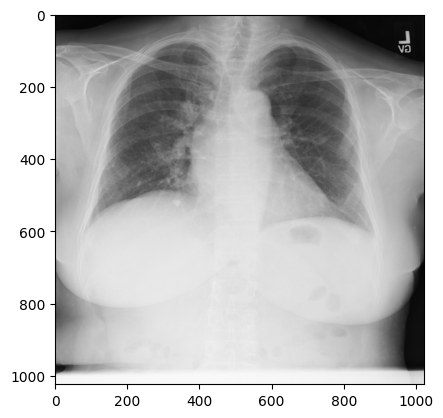

In [45]:
for path in df_experimento['path']:
    img = cv2.imread(path)
    # print(img)
    # print(np.unique(img))
    plt.imshow(img)
    break

In [23]:
labels = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "No Finding",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax"] 

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [51]:
datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True
)
generator = datagen.flow_from_dataframe(
    dataframe=df_experimento,
    directory=None,
    x_col='path_crop',
    y_col=labels,
    class_mode="raw",
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
)
x, y = generator.__getitem__(0)

Found 100 validated image filenames.
